In [106]:
pip install -r requirements.txt

     |████████████████████████████████| 102kB 2.0MB/s ta 0:00:011
  Stored in directory: /Users/yuanwenliang/Library/Caches/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


## Vegetation Index
### *Using NDVI (Normalized Difference Vegetation Index)

To calculate the NDVI, we need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

$$NDVI = \frac{nir - red}{nir + red} $$


We use `rasterio` here to calculate and visualize ndvi. Rasterio document: https://rasterio.readthedocs.io/en/stable/quickstart.html

In [1]:
import rasterio as rio
from rasterio import plot
import numpy as np
from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import colors



# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

# The expected value of a Pixel in a mask file indicating that the pixel is
# within that region.  Tuple value, (Red, Green, Blue, Alpha)
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

def get_cropped_image_paths(tile_x, tile_y, band, date):
    path = f"../data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def get_timeseries_image_paths(tile_x, tile_y, band, date):
    path = f"../data/sentinel-2a-tile-{tile_x}x-{tile_y}y/timeseries/{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def get_band(tile_x, tile_y, date, band, cropped = False):
    if cropped == True:
        path = get_cropped_image_paths(tile_x, tile_y, band, date)
    else:
        path = get_timeseries_image_paths(tile_x, tile_y, band, date)
    
    b = rio.open(path)
    read = normalize(b.read(1))
    
    get_band = dict()
    get_band['read'] = read; get_band['b'] = b

    return get_band
   

In [2]:
def NDVI(tile_x, tile_y, date, img = 'NDVI'):
    get_red = get_band(tile_x, tile_y, date, band='B04')
    red = get_red['read']
    b4 = get_red['b']
    
    get_nir = get_band(tile_x, tile_y, date, band='B08')
    nir = get_nir['read']
    b8 = get_nir['b']
    
    get_green = get_band(tile_x, tile_y, date, band='B03')
    b3 = get_green['b']; green = get_green['read']
   
    ndvi = np.where((nir+red)==0., 0, (nir-red)/(nir+red))

    # Stack bands
    ndvi = np.dstack((nir, ndvi, green))

    # View the color composite
    plt.imshow(ndvi)
    plt.savefig(f'../Output/ndvimap-{tile_x}-{tile_y}-{date}.png')

    return ndvi

/anaconda3/envs/mlsa/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


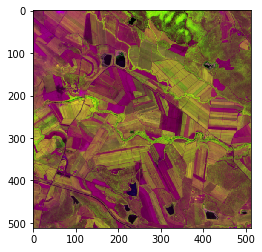

In [3]:
ndvi = NDVI(TILE_X, TILE_Y,'2016-12-22')


At least three types of vegetation can be discriminated in this colour composite image: green, bright yellow and golden yellow areas. The green areas consist of dense trees with closed canopy. The bright yellow areas are covered with shrubs or less dense trees. The golden yellow areas are covered with green fields. The non vegetated areas appear in dark blue and magenta.

These ones don't work.

    #export false color image
    meta = dict(driver='Gtiff',
            width=b2.width, height=b2.height,
            count=3, crs=b2.crs,
            transform=b2.transform,
            dtype='float64')
    
    layer_list = ['nir','red', 'green']

    with rio.open(f'./Output/fci-{tile_x}-{tile_y}-{date}.png','w', **meta) as dst:
        for index, layer in enumerate(layer_list, start=1):
            dst.write(layer,int(index))
   
    # show FCI, can remove
    FCI = rio.open(f'./Output/fci-{tile_x}-{tile_y}-{date}.png', count=3)
    plot.show(FCI)








    ndviImage = rio.open(f'./Output/ndvimap-{tile_x}-{tile_y}-{date}.png',
                         'w',driver='Gtiff',
                          width=b4.width, 
                          height = b4.height, 
                          count=1, crs=b4.crs, 
                          transform=b4.transform, 
                          dtype='float64')
    
    ndviImage.write(ndvi,1)
    ndviImage.close()
    
    #show ndvi, can remove
    ndviImg = rio.open(f'./Output/ndvimap-{tile_x}-{tile_y}-{date}.png')
    plot.show(ndviImg)









    #export false color image
    TCI = rio.open(f'./Output/tci-{tile_x}-{tile_y}-{date}.png',
                               'w', driver='Gtiff',
                               width=b4.width, height=b4.height,
                               count=3, crs=b4.crs,
                               transform=b4.transform,
                               dtype='float64')
    TCI.write(blue,1) 
    TCI.write(green,2) 
    TCI.write(red,3) 
    TCI.close()
    
    # show TCI, can remove
    TCI = rio.open(f'./Output/tci-{tile_x}-{tile_y}-{date}.png', count=3)
    plot.show(TCI)

